<a href="https://colab.research.google.com/github/alfiia-sharafutdinova/pytorch_project/blob/main/pytorch_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs Cats. EfficientNet_V2_S

Here is the code for making scripts for data loading, model initiation, training and evaluation.


### Project Structure

This project will be structured in the following way:

```
pytorch_project/
├── pytorch_project/
│   ├── data_setup.py
│   ├── engine.py
│   ├── model.py
│   ├── train.py
│   └── utils.py
├── models/
│   ├── model_1.pth
│   └── model_2.pth
└── data/
    ├── data_folder_1/
    └── data_folder_2/
```

Here, the top level directory is called `pytorch_project`.

Inside there's another directory called `pytorch_project` which contains `.py` scripts, the purposes of these are:
* `data_setup.py` - a file to prepare data (and download data if needed).
* `engine.py` - a file containing various training functions.
* `model_builder.py` or `model.py` - a file to create a PyTorch model.
* `train.py` - a file to leverage all other files and train a target PyTorch model.
* `utils.py` - a file dedicated to helpful utility functions.

> **Note:** For more on structuring Python projects, see Real Python's [*Python Application Layouts: A Reference*](https://realpython.com/python-application-layouts/) guide.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


## 0. Creating a folder for storing Python scripts

We'll call the folder `pytorch_project` and create it using Python's [`os.makedirs()`](https://docs.python.org/3/library/os.html) method.

In [ ]:
import os

os.makedirs("pytorch_project", exist_ok=True)

## 1. Get data

We're going to start by downloading data from Kaggle [Dogs & Cats Images](https://www.kaggle.com/datasets/chetankv/dogs-cats-images) dataset. We will use Kaggle API.

In [ ]:
import os

# your Kaggle username and key
os.environ['KAGGLE_USERNAME'] = "..."
os.environ['KAGGLE_KEY'] = "..."

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [ ]:
import os
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "dogs_cats"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download data
api.dataset_download_files('chetankv/dogs-cats-images', path=data_path)
print("Downloading dogs, cats data...")
    

# Unzip data
with zipfile.ZipFile(data_path / "dogs-cats-images.zip", "r") as zip_ref:
    print("Unzipping dogs, cats data...") 
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "dogs-cats-images.zip")

Did not find data/dogs_cats directory, creating one...
Unzipping dogs, cats data...


In [ ]:
# Setup train and testing paths
train_dir = image_path / "dataset" / "training_set"
test_dir = image_path / "dataset" / "test_set"

train_dir, test_dir

(PosixPath('data/dogs_cats/dataset/training_set'),
 PosixPath('data/dogs_cats/dataset/test_set'))

Image height: 280
Image width: 300


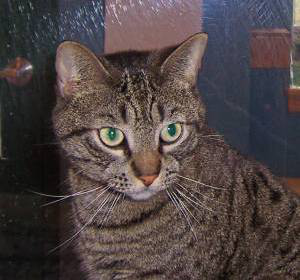

In [ ]:
from PIL import Image
from pathlib import Path

# Open image
img = Image.open(image_path / "dataset" / "training_set" / "cats" / "cat.1.jpg")

# Print metadata
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## 2. Making scripts

Here we're making scripts:
* `data_setup.py` for creating PyTorch DataLoaders for image classification data; 
* `engine.py` with functions for training and testing PyTorch models;
* a helper script `utils.py` with function to save a model;
* `train.py` for retraining a pretrained PyTorch `efficientnet_v2_s` model using device-agnostic code.

In [ ]:
%%writefile pytorch_project/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing pytorch_project/data_setup.py


In [ ]:
%%writefile pytorch_project/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Writing pytorch_project/engine.py


In [ ]:
%%writefile pytorch_project/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
from pathlib import Path

import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing pytorch_project/utils.py


In [ ]:
%%writefile pytorch_project/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os

import torch

import torchvision

import data_setup, engine, utils


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup directories
train_dir = "data/dogs_cats/dataset/training_set"
test_dir = "data/dogs_cats/dataset/test_set"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
auto_transforms = weights.transforms()

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=BATCH_SIZE
)

# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="EfficientNet_V2_S_Retrained.pth")

Overwriting pytorch_project/train.py


## 3. Experiment

### Imports and device setting

Here we import everything necessary for our experiment.

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Import the pytorch_project scripts
from pytorch_project import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data setup

We need to transform our data in a format that is suitable for EfficientNet_V2_S. To do this we need to intialize weights of a pretrained model and than use `transform()` method.

In [ ]:
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_V2_S_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Now we can create dataloaders using the `data_setup.py`.

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names using data_setup script
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f166943fd60>,
 ['cats', 'dogs'])

### Making a model

Import weights for a pre-trained model.

In [ ]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

# Uncomment to see (Very long)
# model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 116MB/s]


In [ ]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(32, 3, 384, 384), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192

Now we need to retrain the last block called `classifier`. First we need to freeze weights of all the other layers.

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Then we can rewrite `classifier` changing only the `out_features` in `Linear` layer.

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 384, 384), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 

Now we can actually retrain the model. We define the loss and optimizer.

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training the model on 5 epochs.

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1208 | train_acc: 0.9633 | test_loss: 0.0462 | test_acc: 0.9896
Epoch: 2 | train_loss: 0.0599 | train_acc: 0.9794 | test_loss: 0.0376 | test_acc: 0.9921
Epoch: 3 | train_loss: 0.0544 | train_acc: 0.9810 | test_loss: 0.0331 | test_acc: 0.9911
Epoch: 4 | train_loss: 0.0498 | train_acc: 0.9802 | test_loss: 0.0291 | test_acc: 0.9906
Epoch: 5 | train_loss: 0.0486 | train_acc: 0.9832 | test_loss: 0.0282 | test_acc: 0.9916
[INFO] Total training time: 605.434 seconds


Plot loss and accuracy

[INFO] Couldn't find helper_functions.py, downloading...


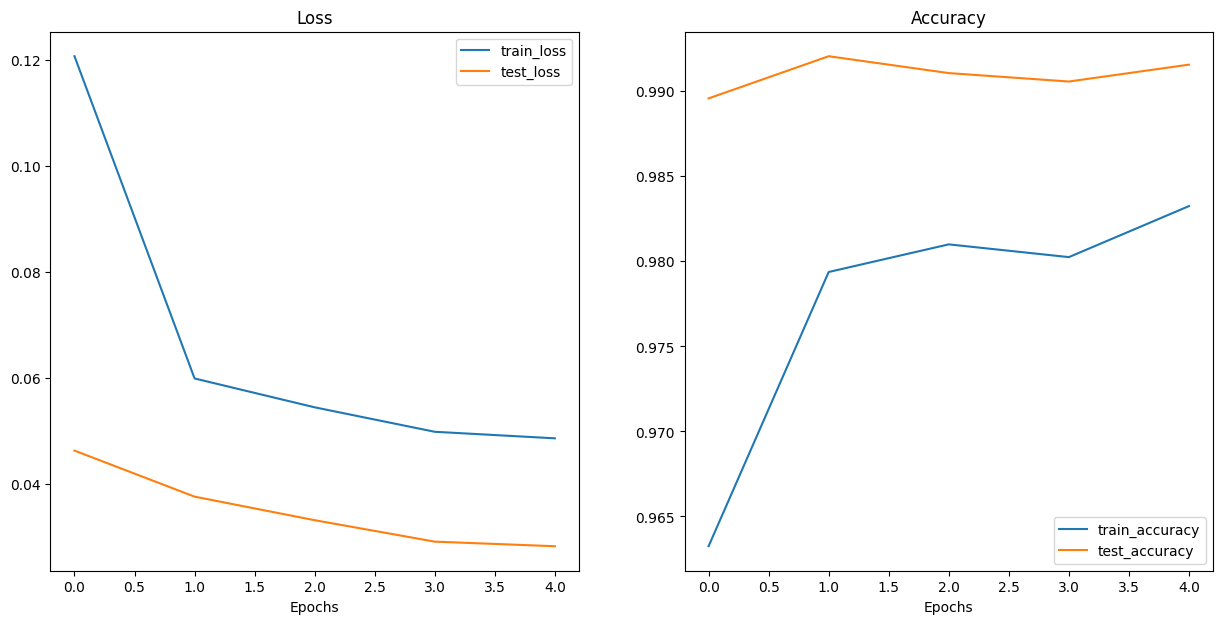

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

Making a fucntion to predict on and to plot an image.

> **Note:** Need to make it into a script also.

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Here we predict on random images from test set

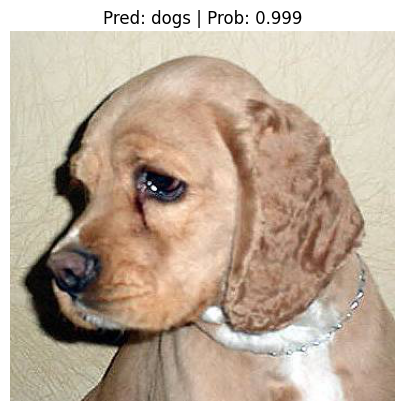

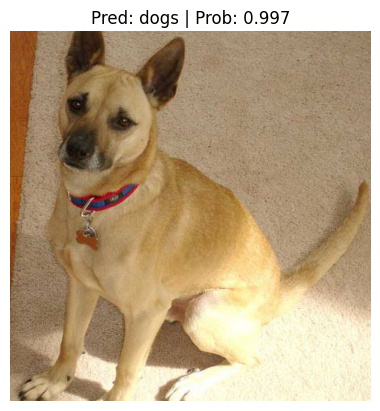

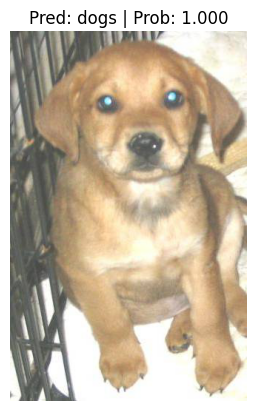

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(384, 384))

Trying to make predictions on some images from internet.

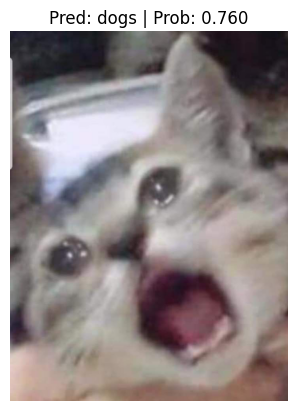

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "01-crying-cat.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://i.pinimg.com/originals/0a/72/ef/0a72efd2abb871f9afb7d31b07142cb2.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

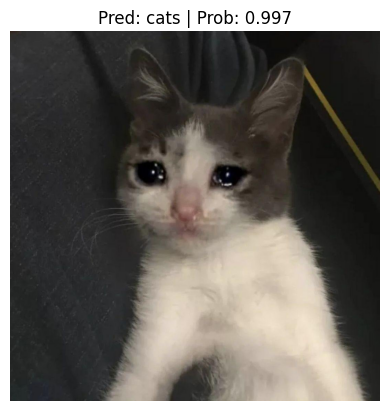

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "02-crying-cat.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://kartinkin.net/uploads/posts/2022-12/1670030594_kartinkin-net-p-plach-koshki-krasivo-27.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

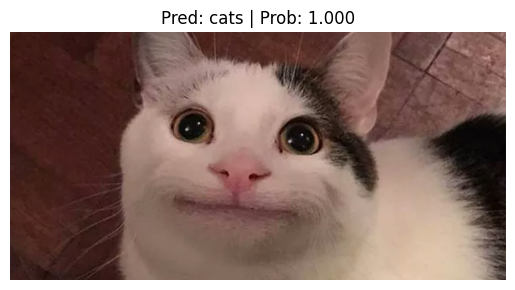

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "01-polite-cat.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://cdn.ccdiscussion.com/original/3X/b/5/b5b284a69d5f5e50897fb23e83890beb70f7bde9.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## 4. Train, evaluate and save the model (script mode)

We will train and save our model using a single line of code with `train.py`.

This will allow us to run all of the functions we've written with a single line of code on the command line:

`python pytorch_project/train.py`

Or if we're running it in a notebook:

`!python pytorch_project/train.py`

We'll go through the following steps:
1. Import the various dependencies, namely `torch`, `os`, `torchvision.transforms` and all of the scripts from the `going_modular` directory, `data_setup`, `engine`, `utils`.
2. Setup various hyperparameters such as batch size, number of epochs, learning rate and number of hidden units (these could be set in the future via [Python's `argparse`](https://docs.python.org/3/library/argparse.html)).
3. Setup the training and test directories.
4. Setup device-agnostic code.
5. Create the necessary data transforms.
6. Create the DataLoaders using `data_setup.py`.
7. Create the model.
8. Setup the loss function and optimizer.
9. Retrain the model using `engine.py`.
10. Save the model using `utils.py`.

In [ ]:
!python pytorch_project/train.py

  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 0.1235 | train_acc: 0.9623 | test_loss: 0.0477 | test_acc: 0.9896
 20% 1/5 [02:12<08:50, 132.52s/it]Epoch: 2 | train_loss: 0.0586 | train_acc: 0.9796 | test_loss: 0.0355 | test_acc: 0.9921
 40% 2/5 [04:22<06:32, 130.78s/it]Epoch: 3 | train_loss: 0.0554 | train_acc: 0.9801 | test_loss: 0.0288 | test_acc: 0.9940
 60% 3/5 [06:23<04:12, 126.30s/it]Epoch: 4 | train_loss: 0.0519 | train_acc: 0.9815 | test_loss: 0.0279 | test_acc: 0.9921
 80% 4/5 [08:26<02:05, 125.16s/it]Epoch: 5 | train_loss: 0.0491 | train_acc: 0.9834 | test_loss: 0.0290 | test_acc: 0.9911
100% 5/5 [10:28<00:00, 125.67s/it]
[INFO] Saving model to: models/EfficientNet_V2_S_Retrained.pth


Now we saved the retrained model in `pytorch_project/models/EfficientNet_V2_S_Retrained.pth`